# Fine-tuning for Semantic Segmentation

This is the code for the project of STATS 507 in University of Michigan.

In this notebook, I'm going to fine tune a pretrained vision model for Semantic Segmentation on a custom dataset in PyTorch. Then a Lut filter will be applied on the image according to the segmentation result to preserve some "characteristic color" such as face and hair.

The report for this project can be found here.

### Model


### Dataset


### Data Augmentation

### Required Libraries

In [2]:
! pip install transformers datasets evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
from typing import Optional, Tuple, List, Dict, Any
from dataclasses import dataclass, field

import numpy as np
import torch
import wandb
import evaluate
from torch import optim, nn
from datasets import load_dataset
from transformers import SegformerImageProcessor, AutoModelForSemanticSegmentation
from torch.utils.data import DataLoader
import albumentations as A

# Code for Fine-Tuning

### Loading the dataset

Load the dataset: Human Parsing Data from

In [3]:
from datasets import load_dataset

# load the dataset and split the train-test
dataset_identifier = "mattmdjaga/human_parsing_dataset"
ds = load_dataset(dataset_identifier, split="train[:100%]", num_proc=8)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/4.01k [00:00<?, ?B/s]

Setting num_proc from 8 to 2 for the train split as it only contains 2 shards.


Generating train split:   0%|          | 0/17706 [00:00<?, ? examples/s]

Check the samples

In [4]:
ds

Dataset({
    features: ['image', 'mask'],
    num_rows: 17706
})

There are 17706 samples in this dataset.

The `ds` object is a `DatasetDict`, which contains one "train" split. The `features` tell us what each sample is consisted of:

- `image`: the actual image
- `mask`: segmentation mask

One example is shown down below.

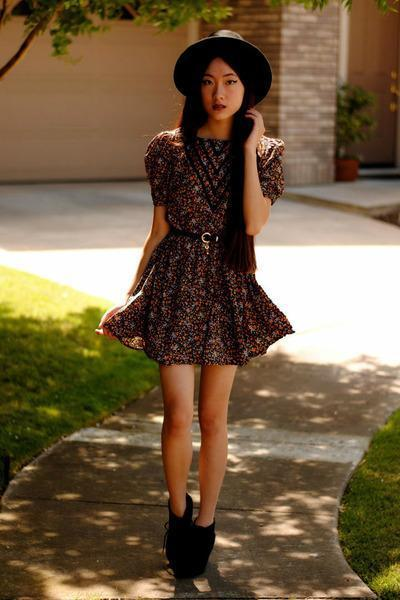

In [13]:
example = ds[5]
# example["image"].save("3.png")
example["image"]

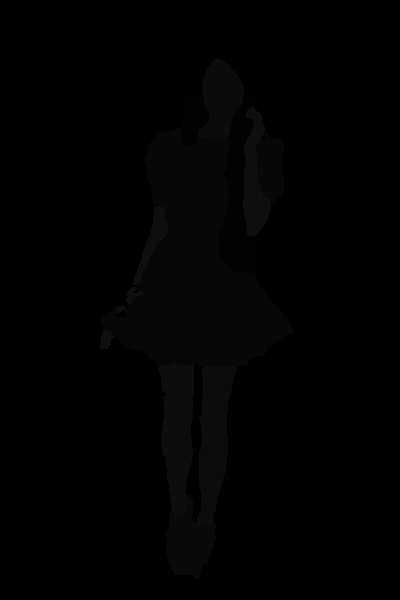

In [14]:
example["mask"]

Each of the pixels above in the mask image is associated to a particular category. Here I defined an `id2label` dictionary to decode them back to strings and see what they are. The inverse `label2id` is also useful when we

In [ ]:
id2label: Dict[str, str] = {
    "0": "Background",
    "1": "Hat",
    "2": "Hair",
    "3": "Sunglasses",
    "4": "Upper-clothes",
    "5": "Skirt",
    "6": "Pants",
    "7": "Dress",
    "8": "Belt",
    "9": "Left-shoe",
    "10": "Right-shoe",
    "11": "Face",
    "12": "Left-leg",
    "13": "Right-leg",
    "14": "Left-arm",
    "15": "Right-arm",
    "16": "Bag",
    "17": "Scarf",
}

label2id: Dict[str, str] = {v: k for k, v in id2label.items()}
num_labels = len(id2label)

Shuffle the dataset, and then split them into training and testing sets.

In [15]:
ds.shuffle(seed=1)

split_ratio = 0.006
split_size = int(len(ds) * split_ratio)
print(f"Testing data size: {split_size}")

ds_split = ds.train_test_split(test_size=split_ratio, seed=1)
train_ds = ds_split["train"]
test_ds = ds_split["test"]

Split size: 106


106 of the samples are split for testing.

### Preprocess the data

Before we feed these images to the model, we need to preprocess them.

Preprocessing images typically comes down to (1) resizing them to a particular size (2) normalizing the color channels (R,G,B) using a mean and standard deviation. These are referred to as **image transformations**.

To make sure we (1) resize to the appropriate size (2) use the appropriate image mean and standard deviation for the model architecture we are going to use, we instantiate what is called a feature extractor with the `AutoFeatureExtractor.from_pretrained` method.

This feature extractor is a minimal preprocessor that can be used to prepare images for model training and inference.

In [ ]:
# Image Transformations
img_transforms = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.OneOf(
            [
                A.Downscale(p=0.1, scale_min=0.4, scale_max=0.6),
                A.GaussNoise(p=0.2),
            ],
            p=0.1,
        ),
        A.OneOf(
            [
                A.RandomBrightnessContrast(p=0.2),
                A.ColorJitter(p=0.2),
                A.HueSaturationValue(p=0.2),
            ],
            p=0.1,
        ),
        A.OneOf([A.PixelDropout(p=0.2), A.RandomGravel(p=0.2)], p=0.15),
    ]
)

In [ ]:
# Dataset Transformation Functions
def train_transforms(example_batch):

    trans = [
        img_transforms(image=np.array(x), mask=np.array(m))
        for x, m in zip(example_batch["image"], example_batch["mask"])
    ]
    images = [x["image"] for x in trans]
    labels = [x["mask"] for x in trans]
    inputs = tokenizer(images, labels)
    return inputs


def val_transforms(example_batch):
    images = [x for x in example_batch["image"]]
    labels = [x for x in example_batch["mask"]]
    inputs = tokenizer(images, labels)
    return inputs


train_ds.set_transform(train_transforms)
test_ds.set_transform(val_transforms)

Let us also load the Mean IoU metric, which we'll use to evaluate our model both during and after training.

Let us also load the Mean IoU metric, which we'll use to evaluate our model both during and after training.

IoU (short for Intersection over Union) tells us the amount of overlap between two sets. In our case, these sets will be the ground-truth segmentation map and the predicted segmentation map. To learn more, you can check out [this article](https://learnopencv.com/intersection-over-union-iou-in-object-detection-and-segmentation/).

In [ ]:
import evaluate

# Metrics and Validation
metric = evaluate.load("mean_iou")


@torch.no_grad()
def compute_metrics(eval_pred):

    logits, labels = eval_pred
    logits_tensor = logits.argmax(dim=1)

    pred_labels = logits_tensor

    mets = metric.compute(
        predictions=pred_labels,
        references=labels,
        num_labels=num_labels,
        ignore_index=255,
        reduce_labels=False,
    )
    for key, value in mets.items():
        if type(value) is np.ndarray:
            mets[key] = value.tolist()

    return mets


@torch.no_grad()
def validation(model, val_loader):

    model.eval()
    val_losses = []
    all_labels = []
    all_logits = []

    for i, batch in enumerate(val_loader, 1):
        inputs = batch["pixel_values"].to(config.device)
        labels = batch["labels"].to(config.device)

        outputs = model(inputs)
        logits_tensor = nn.functional.interpolate(
            outputs.logits,  # Detach to avoid saving gradients
            size=labels.shape[-2:],
            mode="bilinear",
            align_corners=False,
        )

        loss = loss_func(logits_tensor, labels)
        val_losses.append(loss.item())

        # Storing logits and labels as CPU tensors to save GPU memory
        all_labels.append(labels.cpu())
        all_logits.append(logits_tensor.cpu())

    # Concatenate all logits and labels
    logits = torch.cat(all_logits, dim=0).to(config.device)
    labels = torch.cat(all_labels, dim=0).to(config.device)

    model.train()
    return logits, labels, val_losses

### Load the model

In [ ]:
# Model and Tokenizer Initialization
tokenizer = SegformerImageProcessor.from_pretrained(config.model_name)
tokenizer.do_center_crop = False

model = AutoModelForSemanticSegmentation.from_pretrained(
    config.model_name, num_labels=num_labels, id2label=id2label, label2id=label2id, ignore_mismatched_sizes=True
).to(config.device)

Define function to save the model

In [ ]:
def save_model(model: nn.Module, tokenizer: SegformerImageProcessor, name: str) -> None:
    model.save_pretrained(name)
    tokenizer.save_pretrained(name)

In [ ]:
# DataLoader, Optimizer, and Scheduler
train_loader = DataLoader(train_ds, batch_size=config.batch_size, shuffle=True)
val_loader = DataLoader(test_ds, batch_size=config.batch_size, shuffle=False)
optimizer = optim.AdamW(model.parameters(), lr=config.learning_rate)
lambda1 = lambda step: config.lr_decay_rate**step
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

weights = torch.tensor(
    [config.background_weight] + [config.other_classes_weight] * 17
).to(config.device)
loss_func = nn.CrossEntropyLoss(weight=weights)

Configuration of the process

In [ ]:
@dataclass
class TrainingConfig:
    batch_size: int = 8
    epochs: int = 8
    learning_rate: float = 1e-4
    background_weight: float = 1.0
    other_classes_weight: float = 3.0
    lr_decay_rate: float = 0.9998
    seed: int = 42
    model_name: str = "apple/deeplabv3-mobilevit-small"
    device = field(default_factory=lambda: "cuda" if torch.cuda.is_available() else "cpu")


config = TrainingConfig()

### Train the model

In [ ]:
running_loss = []


for epoch in range(config.epochs):
    for i, batch in enumerate(train_loader):
        optimizer.zero_grad()
        inputs = batch["pixel_values"].to(config.device)
        labels = batch["labels"].to(config.device)
        outputs = model(inputs)
        # The models predicts small masks, so we need to upsample them to the correct size like in inference
        logits_tensor = nn.functional.interpolate(
            outputs.logits,
            size=labels.shape[-2:],
            mode="bilinear",
            align_corners=False,
        )
        loss = loss_func(logits_tensor, labels)
        running_loss.append(loss.item())

        loss.backward()
        optimizer.step()
        scheduler.step()

        if (i + 1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{config.epochs}], Step [{i+1}/{len(train_loader)}], Loss: {sum(running_loss)/len(running_loss):.4f}")
            running_loss = []

        if t_steps % 600 == 0:
            wandb_logs = {}

            last_lr = scheduler.get_last_lr()[0]

            logits_tensor, labels, val_losses = validation(model, val_loader)
            r_loss = sum(running_loss) / len(running_loss)
            val_loss = sum(val_losses) / len(val_losses)

            mets = compute_metrics((logits_tensor, labels))

            wandb_logs["training_loss"] = r_loss
            wandb_logs["val_loss"] = val_loss

            for key, value in mets.items():
                if isinstance(value, float):
                    wandb_logs[key] = value

            print(f"\nEpoch {epoch} Iteration {i}")
            for key, score in wandb_logs.items():
                print(f"{key}: {score:.3f}")

            print(f"LR: {last_lr}")
            wandb_logs["LR"] = last_lr
            wandb.log(wandb_logs)
            running_loss = []
        t_steps += 1
    save_model(model, tokenizer, f"{epoch}")

In [ ]:
# Main Training Loop
for epoch in range(config.epochs):
    running_loss = []

    for i, batch in enumerate(train_loader):
        optimizer.zero_grad()
        inputs = batch["pixel_values"].to(config.device)
        labels = batch["labels"].to(config.device)
        outputs = model(inputs)

        logits_tensor = nn.functional.interpolate(
            outputs.logits,
            size=labels.shape[-2:],
            mode="bilinear",
            align_corners=False,
        )

        loss = loss_func(logits_tensor, labels)
        running_loss.append(loss.item())

        loss.backward()
        optimizer.step()
        scheduler.step()

        if (i + 1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{config.epochs}], Step [{i+1}/{len(train_loader)}], Loss: {sum(running_loss)/len(running_loss):.4f}")
            running_loss = []

    # Validate after each epoch
    val_losses = validation(model, val_loader)
    print(f"Epoch [{epoch+1}/{config.epochs}], Validation Loss: {sum(val_losses)/len(val_losses):.4f}")

    # Save model after each epoch
    save_dir = "saved_models"
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    model_path = os.path.join(save_dir, f"epoch_{epoch}")
    model.save_pretrained(model_path)
    tokenizer.save_pretrained(model_path)

# Inference

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

The performance of the original model before fine tuning.

In [1]:
from transformers import AutoFeatureExtractor, AutoModelForSemanticSegmentation
from PIL import Image
import requests
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [88]:
# apple model performance
model_name = "apple/deeplabv3-mobilevit-small"
original_processor = AutoFeatureExtractor.from_pretrained(model_name)
original_processor.do_center_crop = False
original_model = AutoModelForSemanticSegmentation.from_pretrained(model_name).to("cuda" if torch.cuda.is_available() else "cpu")

# load the image
# url = "https://plus.unsplash.com/premium_photo-1673210886161-bfcc40f54d1f?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxzZWFyY2h8MXx8cGVyc29uJTIwc3RhbmRpbmd8ZW58MHx8MHx8&w=1000&q=80"
# image = Image.open(requests.get(url, stream=True).raw)
image = Image.open("3.png")

# pre-process the image
inputs = original_processor(images=image, return_tensors="pt").to("cuda" if torch.cuda.is_available() else "cpu")

# apply the model
outputs = original_model(**inputs)
logits = outputs.logits

# up sample the mask to the original size
upsampled_logits = nn.functional.interpolate(
    logits,
    size=image.size[::-1],
    mode="bilinear",
    align_corners=False,
)

# get the segmentation result
pred_seg_original = upsampled_logits.argmax(dim=1)[0].cpu()

/usr/local/lib/python3.10/dist-packages/transformers/models/mobilevit/feature_extraction_mobilevit.py:28: FutureWarning: The class MobileViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use MobileViTImageProcessor instead.
  warnings.warn(


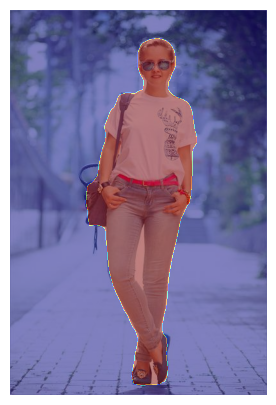

In [89]:
# overlay the mask result on the image
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(image)
ax.imshow(pred_seg_original, cmap="jet", alpha=0.5)  # transparent mask
ax.axis("off")
plt.show()

Model after fine tuning.

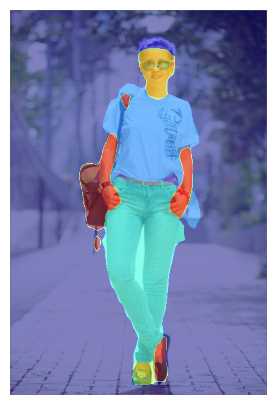

In [90]:
# load the model from fine tuning
model_dir = "./7"

model = AutoModelForSemanticSegmentation.from_pretrained(model_dir).to("cuda" if torch.cuda.is_available() else "cpu")

# apply the model
outputs = model(**inputs)
logits = outputs.logits

# up sample the mask to the original size
upsampled_logits = nn.functional.interpolate(
    logits,
    size=image.size[::-1],
    mode="bilinear",
    align_corners=False,
)

# get the segmentation result
pred_seg = upsampled_logits.argmax(dim=1)[0].cpu()

# overlay the mask result on the image
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(image)
ax.imshow(pred_seg, cmap="jet", alpha=0.5)  # transparent mask
ax.axis("off")
plt.show()

# Applying the Lut to the image

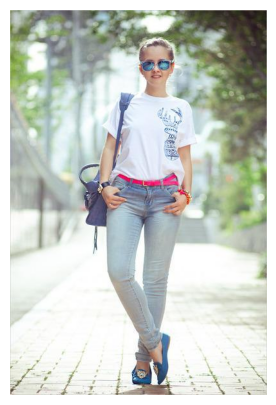

In [91]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(image)
ax.axis("off")
plt.show()

In [54]:
pip install pillow pillow-lut

  Preparing metadata (setup.py) ... done
  Created wheel for pillow-lut: filename=pillow_lut-1.0.1-py3-none-any.whl size=10473 sha256=e3a572be4feb9011ef30f0e3639b9489d199ec4203c65a20068eee8611796f5b
  Stored in directory: /root/.cache/pip/wheels/c1/c9/b0/e80cbc8b67d6d193d9932946a0570a363175a192df879a8436
Successfully built pillow-lut


In [102]:
from PIL import Image
from pillow_lut import load_cube_file

lut = load_cube_file("./Duotone.cube")
im = Image.open("3.png")
im.filter(lut).save("image-with-lut-applied.png")

Start to apply filter to part of the image.

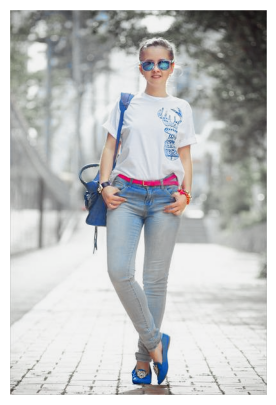

In [104]:
from PIL import Image
import numpy as np

# load the image
# im = Image.open("1.jpeg")
im = image
im_lut = Image.open("image-with-lut-applied.png")
# mask = Image.open("mask.png")
mask = pred_seg

# change to NumPy array
mask_array = np.array(mask)
im_array = np.array(im)
im_lut_array = np.array(im_lut)

# categories for skin
categories_to_keep = [11, 12, 13, 14, 15]

# mask for skin
keep_mask = np.isin(mask_array, categories_to_keep)

final_image_array = np.where(keep_mask[..., None], im_array, im_lut_array)

# save and plot the image
final_image = Image.fromarray(final_image_array.astype('uint8'))
final_image.save("final_image2.png")
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(final_image)
ax.axis("off")
plt.show()

summarize how many pixel points in each class in the mask image.

In [57]:
# pred_seg

unique_values, counts = torch.unique(pred_seg, return_counts=True)

# make a table
table = {int(value.item()): count.item() for value, count in zip(unique_values, counts)}

# print result
print("Value - Count")
for value, count in table.items():
    print(f"{value} - {count}")

Value - Count
0 - 1158071
1 - 90
2 - 6207
4 - 210231
6 - 94859
11 - 23773
14 - 21
15 - 2127
16 - 4621
